# Modeling test - Echocardiogram

## Subject Description
We would like you to do the practical exercise with this dataset. It has data from patients that have suffered at least one heart attack, and the goal is to predict which of them survive for over a year. You should send us any data analysis , or visualization you consider useful to this effect, and/or the results of any predictive modeling approach you find suitable, as well as the code used to produce them. There is absolutely no constraint regarding which approach, techniques, tools, or programming language to use.


## Objective
The objective of this practical exercise is to predict if a patient survive for over a year after suffering at least one heart attack. The dataset provide by Steven Salzberg ([UCI Echocardiogram](https://archive.ics.uci.edu/ml/datasets/echocardiogram)) have 13 variables measured from 132 patients. 

We are going to solve an supervised learning problem.

## Import packages
Importing some useful python packages

In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import missingno  as msno
import janitor as jn
from ydata_profiling import ProfileReport
from sklearn import (
ensemble,
preprocessing,
tree,
)
from sklearn.metrics import (
auc,
confusion_matrix,
roc_auc_score,
roc_curve,
)
from sklearn.model_selection import (
train_test_split,
StratifiedKFold,
)
from yellowbrick.classifier import (
confusion_matrix,
ROCAUC,
)
from yellowbrick.model_selection import (
LearningCurve,
)

In [2]:
%matplotlib inline

## Load data

In [3]:
path = '../datasets/echocardiogram.data'
columns=['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 'epss',
        'lvdd', 'wall-motion-score', 'wall-motion-index', 'mult', 'name', 'group', 'alive-at-1']
org_df = pd.read_csv(path, names=columns, on_bad_lines='skip', na_values=['?'])

In our first loading, something is wrong at line 50. There exists an extra field somewhere, we decide to skip this bad line.
We also replace missing values indicated by "**?**" with **NaN**

In [4]:
org_df.head()

survival  still-alive  age-at-heart-attack  pericardial-effusion  \
0      11.0            0                 71.0                     0   
1      19.0            0                 72.0                     0   
2      16.0            0                 55.0                     0   
3      57.0            0                 60.0                     0   
4      19.0            1                 57.0                     0   

   fractional-shortening    epss   lvdd  wall-motion-score  wall-motion-index  \
0                  0.260   9.000  4.600               14.0               1.00   
1                  0.380   6.000  4.100               14.0               1.70   
2                  0.260   4.000  3.420               14.0               1.00   
3                  0.253  12.062  4.603               16.0               1.45   
4                  0.160  22.000  5.750               18.0               2.25   

    mult  name  group  alive-at-1  
0  1.000  name    1.0         0.0  
1  0.588  name    1.0         0.0  
2  1.000  name    1.0         0.0  
3  0.788  name    1.0         0.0  
4  0.571  name    1.0         0.0

In [ ]:
org_df.shape

Now, we get 131 rows instead of 132 and 13 columns

### Data Dictionnary.
The following lines describes details of each attribute :
1. **survival** -- the number of months patient survived (has survived,
		  if patient is still alive).  Because all the patients
		  had their heart attacks at different times, it is 
		  possible that some patients have survived less than
		  one year but they are still alive.  Check the second
		  variable to confirm this.  Such patients cannot be 
		  used for the prediction task mentioned above.
2. **still-alive** -- a binary variable.  0=dead at end of survival period,
		     1 means still alive 
3. **age-at-heart-attack** -- age in years when heart attack occurred
4. **pericardial-effusion** -- binary. Pericardial effusion is fluid
			      around the heart.  0=no fluid, 1=fluid
5. **fractional-shortening** -- a measure of contracility around the heart
			       lower numbers are increasingly abnormal
6. **epss** -- E-point septal separation, another measure of contractility.  
	      Larger numbers are increasingly abnormal.
7. **lvdd** -- left ventricular end-diastolic dimension.  This is
	      a measure of the size of the heart at end-diastole.
	      Large hearts tend to be sick hearts.
8. **wall-motion-score** -- a measure of how the segments of the left
			   ventricle are moving
9. **wall-motion-index** -- equals wall-motion-score divided by number of
			   segments seen.  Usually 12-13 segments are seen
			   in an echocardiogram.  Use this variable INSTEAD
			   of the wall motion score.
10. **mult** -- a derivate var which can be ignored
11. **name** -- the name of the patient (I have replaced them with "name")
12. **group** -- meaningless, ignore it
13. **alive-at-1** -- Boolean-valued. Derived from the first two attributes.
                     0 means patient was either dead after 1 year or had
                     been followed for less than 1 year.  1 means patient 
                     was alive at 1 year.


We save the correct dataset with header as a CSV format

In [5]:
org_df.to_csv('../datasets/raw/echocardiogram.csv', index=False)

In [6]:
!head -5 ../datasets/raw/echocardiogram.csv

survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
11.0,0,71.0,0,0.26,9.0,4.6,14.0,1.0,1.0,name,1.0,0.0
19.0,0,72.0,0,0.38,6.0,4.1,14.0,1.7,0.588,name,1.0,0.0
16.0,0,55.0,0,0.26,4.0,3.42,14.0,1.0,1.0,name,1.0,0.0
57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.788,name,1.0,0.0


## Exploratory Data Analysis

In these step, we use descriptive statistics and visualization to analyze variables. These help to understand how data are distributed, and how variables are corraleted, how outliers and missing values impact the correctedness of the dataset. 

We also need to check the format of each feature, because, many machine learning models work only with numerical variables. Hence, the categorical variables need to be transformed as numerical.

In [7]:
df = pd.read_csv("../datasets/raw/echocardiogram.csv")
df.head()

survival  still-alive  age-at-heart-attack  pericardial-effusion  \
0      11.0            0                 71.0                     0   
1      19.0            0                 72.0                     0   
2      16.0            0                 55.0                     0   
3      57.0            0                 60.0                     0   
4      19.0            1                 57.0                     0   

   fractional-shortening    epss   lvdd  wall-motion-score  wall-motion-index  \
0                  0.260   9.000  4.600               14.0               1.00   
1                  0.380   6.000  4.100               14.0               1.70   
2                  0.260   4.000  3.420               14.0               1.00   
3                  0.253  12.062  4.603               16.0               1.45   
4                  0.160  22.000  5.750               18.0               2.25   

    mult  name  group  alive-at-1  
0  1.000  name    1.0         0.0  
1  0.588  name    1.0         0.0  
2  1.000  name    1.0         0.0  
3  0.788  name    1.0         0.0  
4  0.571  name    1.0         0.0

In [8]:
df.describe()

survival  still-alive  age-at-heart-attack  pericardial-effusion  \
count  130.000000   131.000000           126.000000            131.000000   
mean    22.182923     0.328244            62.813722              0.183206   
std     15.858267     0.471377             8.342110              0.388320   
min      0.030000     0.000000            35.000000              0.000000   
25%      7.875000     0.000000            57.000000              0.000000   
50%     23.500000     0.000000            62.000000              0.000000   
75%     33.000000     1.000000            67.750000              0.000000   
max     57.000000     1.000000            86.000000              1.000000   

       fractional-shortening        epss        lvdd  wall-motion-score  \
count             124.000000  117.000000  121.000000         128.000000   
mean                0.216734   12.164769    4.763157          14.438125   
std                 0.107513    7.370159    0.810013           5.018566   
min                 0.010000    0.000000    2.320000           2.000000   
25%                 0.150000    7.000000    4.230000          11.000000   
50%                 0.205000   11.000000    4.650000          14.000000   
75%                 0.270000   16.100000    5.300000          16.500000   
max                 0.610000   40.000000    6.780000          39.000000   

       wall-motion-index        mult       group  alive-at-1  
count          130.00000  128.000000  109.000000   74.000000  
mean             1.37800    0.776719    1.779817    0.324324  
std              0.45185    0.199078    0.416284    0.471317  
min              1.00000    0.140000    1.000000    0.000000  
25%              1.00000    0.713000    2.000000    0.000000  
50%              1.21600    0.786000    2.000000    0.000000  
75%              1.50750    0.857000    2.000000    1.000000  
max              3.00000    2.000000    2.000000    1.000000

this function allows to have an overview of decriptive analysis of the variables. 
We observe a highly missing values in variables like `alive-at-1`, `group`, `epss`,`lvdd`.

We also observe outliers in different variable such as `wallmotion-score`,  `wallmotion-index`

We can go futher analysis by using **ydata_profiling** to generate a detailed report of variables

In [10]:
ProfileReport(df)

/home/dmboup/miniconda/envs/env310/lib/python3.10/site-packages/ydata_profiling/profile_report.py:482: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
/home/dmboup/miniconda/envs/env310/lib/python3.10/site-packages/ydata_profiling/report/presentation/flavours/widget/correlation_table.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
/home/dmboup/miniconda/envs/env310/lib/python3.10/site-packages/ydata_profiling/report/presentation/flavours/widget/duplicate.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display
/home/dmboup/miniconda/envs/env310/lib/python3.10/site-packages/ydata_profiling/report/presentati

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

According this report, there are 8 numerical variables and 5 categorical variables.

`name` feature is usless because it has constant values.  
We observe a highly correlation between `stile-alive-1` and `survival` and between `stile-alive-1` and `stile-alive`.

`epss` is highly overall correlated with `lvdd`

`wall-motion-score` is highly overall correlated with `wall-motion-index`


In [11]:
## Save report for exploration
profile = ProfileReport(df)
profile.to_file("../reports/echocardiogram_report.html")

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

**Percentage of missing values**

In [12]:
df.isnull().mean() * 100

survival                  0.763359
still-alive               0.000000
age-at-heart-attack       3.816794
pericardial-effusion      0.000000
fractional-shortening     5.343511
epss                     10.687023
lvdd                      7.633588
wall-motion-score         2.290076
wall-motion-index         0.763359
mult                      2.290076
name                      0.000000
group                    16.793893
alive-at-1               43.511450
dtype: float64

alive-at-1 has high missing values

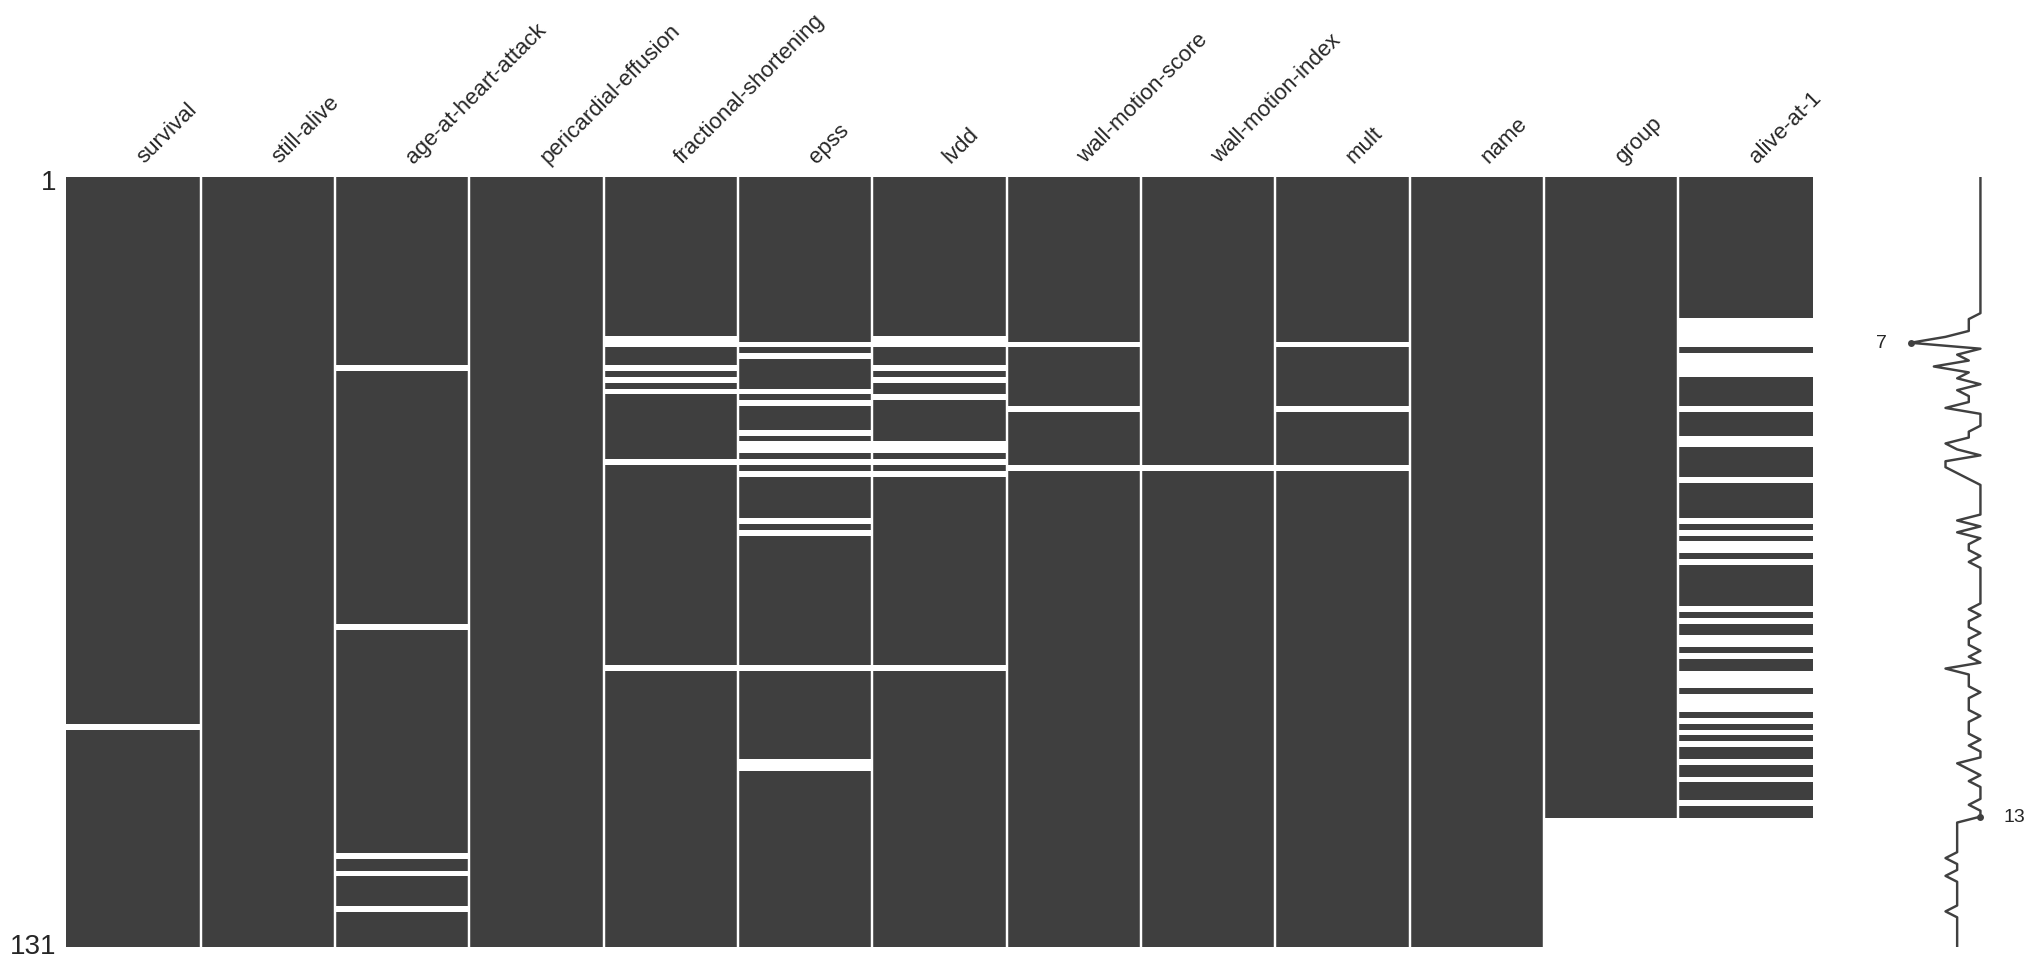

In [14]:
_ = msno.matrix(df)

**How to tackle the problem ?**

What's going on between stile-alive and the survival variables?  
Which variable to choose for prediction ?  

We know that `stile-alive` and the `survival` are highly correlated. 

Authors assumed that :   
  'it is possible that some patients have survived less than  
  one year but they are still alive.  Check the second  
  variable to confirm this.  Such patients cannot be   
  used for the prediction task mentioned above.'  

This quote implies that there are patients who are still alive and they don't tracked as survived.  
Let's check

In [15]:
not_survived = df[df.survival < 12].copy()
not_survived.shape[0]

38

In [16]:
patients_still_alive_not_suvived = df[(df['survival'] < 12) & df['still-alive']].copy()

In [17]:
patients_still_alive_not_suvived

survival  still-alive  age-at-heart-attack  pericardial-effusion  \
10      10.00            1               77.000                     0   
14       0.50            1               62.000                     0   
16       0.50            1               69.000                     1   
17       0.50            1               62.529                     1   
19       1.00            1               66.000                     1   
20       0.75            1               69.000                     0   
21       0.75            1               85.000                     1   
22       0.50            1               73.000                     0   
23       5.00            1               71.000                     0   
28       0.25            1               75.000                     0   
30       1.00            1               65.000                     0   
31       1.00            1               52.000                     1   
32       3.00            1                  NaN                     0   
37       1.00            1               65.000                     0   
44       2.00            1               67.000                     1   
48       0.25            1               63.000                     1   
49       2.00            1               56.000                     1   
50       7.00            1               61.000                     1   
53       1.00            1               60.000                     0   
62       0.50            1               59.000                     0   
65       0.75            1               50.000                     0   
69       0.25            1               86.000                     0   
75       0.25            1               68.000                     0   
76       0.03            1                  NaN                     0   
82       0.75            1               78.000                     0   
83       0.75            1               61.000                     0   
85       1.00            1               73.000                     0   
89       0.50            1               67.000                     0   
97       5.00            1               65.000                     1   
98       4.00            1               58.000                     0   
103      1.25            1               63.000                     0   
107      0.75            1               78.000                     0   
108      3.00            1               62.000                     0   
126      7.50            1               64.000                     0   

     fractional-shortening    epss  lvdd  wall-motion-score  \
10                   0.130  16.000  4.23              18.00   
14                   0.120  23.000  5.80              11.67   
16                   0.260  11.000  4.65              18.00   
17                   0.070  20.000  5.20              24.00   
19                   0.220  15.000  5.40              27.00   
20                   0.150  12.000  5.39              19.50   
21                   0.180  19.000  5.46              13.83   
22                   0.230  12.733  6.06               7.50   
23                   0.170   0.000  4.65               8.00   
28                     NaN     NaN   NaN                NaN   
30                   0.150     NaN  5.05              10.00   
31                   0.170  17.200  5.32              14.00   
32                     NaN  12.000   NaN               6.00   
37                   0.060  23.600   NaN              21.50   
44                   0.440   9.000  3.96              17.50   
48                     NaN     NaN   NaN              23.00   
49                   0.040  14.000  5.00                NaN   
50                   0.270     NaN   NaN               9.00   
53                   0.010  24.600  5.65              39.00   
62                   0.130  16.400  4.96              17.83   
65                   0.140  11.400  4.75              10.00   
69                   0.225  12.200  5.20              24.00   


In [18]:
patients_still_alive_not_suvived.shape[0]

34

In [19]:
len(not_survived) - len(patients_still_alive_not_suvived) 

4

The number of patients who really survived less than a year is 4. 

According the authors, these patients cannot be used for the prediction task mentioned above.

Below, we consider the following sample for the model prediction 

In [20]:
df_sample = df[~((df['survival'] < 12) & df['still-alive'])].copy()

In [21]:
df_sample.shape[0]

97

In [22]:
df_sample['still-alive'].value_counts()

0    88
1     9
Name: still-alive, dtype: int64

The data are imbalance, they need to resample

### Box plots

A box plot is a quick way to show the essential profile of a quantitative statistical series.
it help to analyse how data are distributed and find if there there exists outliers.

Here, we divide the features in two groups according their scale.

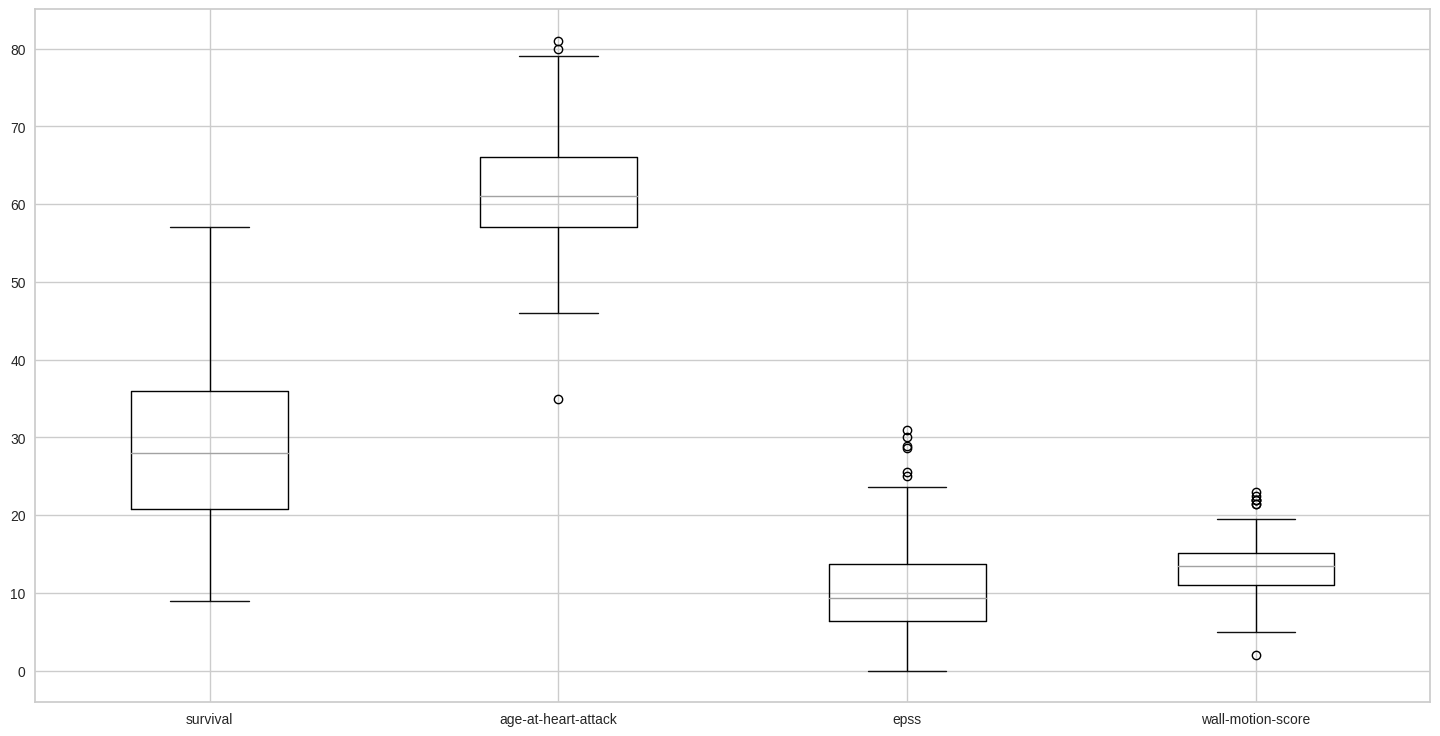

In [27]:
continuous_cols_group1 = ['survival', 'age-at-heart-attack', 'epss','wall-motion-score']
fig, ax = plt.subplots(figsize=(18, 9))
df_sample.boxplot(continuous_cols_group1)
plt.show()

`epss` and `wall-motion-score` have outliers.  
The mean age of heart attack is 63 years and the min age is 35 years. we can conclude that the heart attack concerns frequently old people.

Every patient get on average 27 attacks.


<AxesSubplot: >

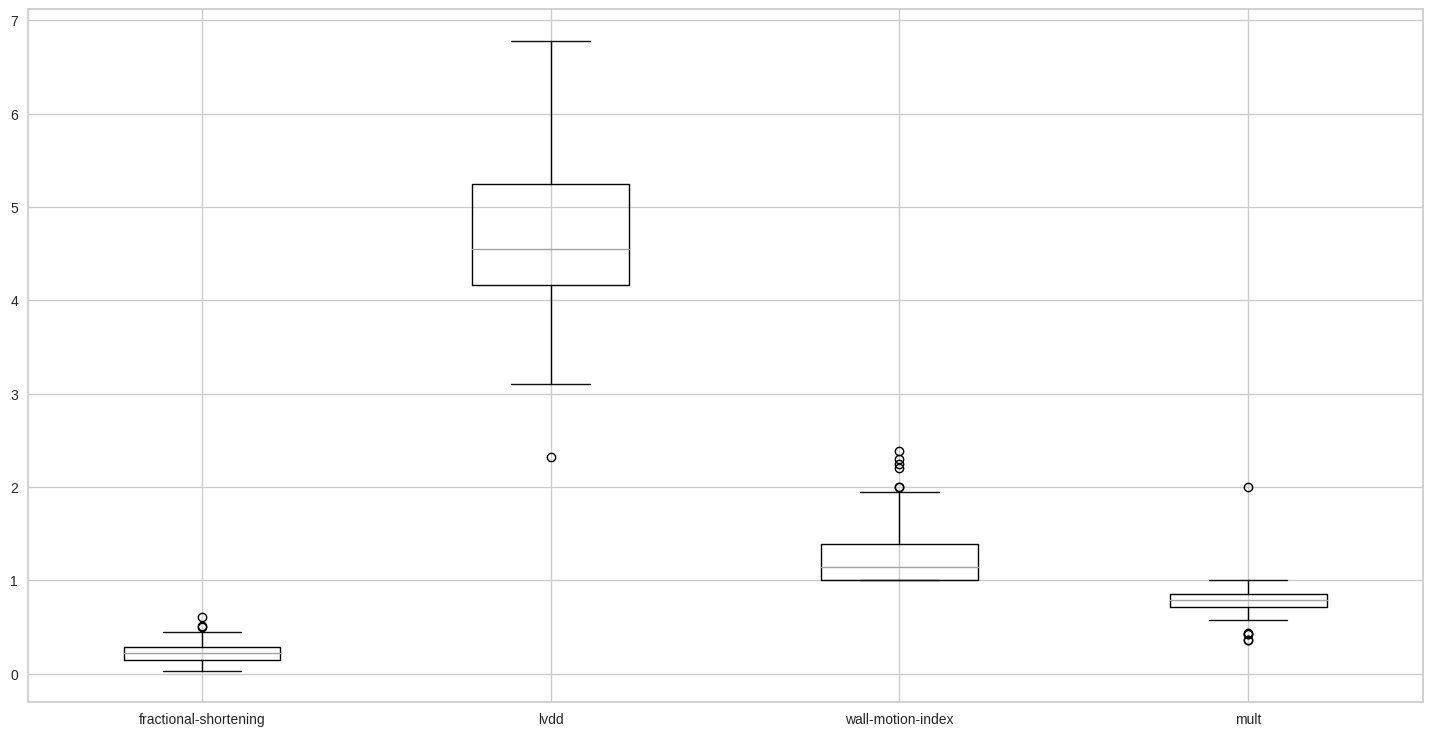

In [28]:
continuous_cols_group2 = [ 'fractional-shortening', 'lvdd', 'wall-motion-index', 'mult']
fig, ax = plt.subplots(figsize=(18, 9))
df_sample.boxplot(continuous_cols_group2)

`wall-motion-index` and `mult` variables present some outliers.

<AxesSubplot: xlabel='still-alive', ylabel='survival'>

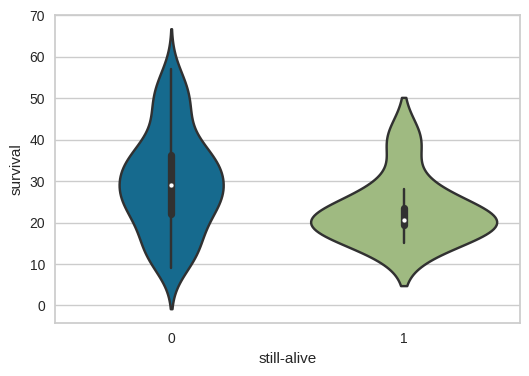

In [31]:
import seaborn as sns
fig, ax = plt.subplots(figsize=(6, 4))
new_df = df_sample.copy()
sns.violinplot(x="still-alive", y="survival", data=new_df)

We observe that survival is well distributed.  
We observe that those who are lucky enough to survive have the maximum of 50 heart attacks.

## Data Preparation

### Drop unuseful columns

`name`, `group` can be ignore.
`mult` can be removed because low correlation.

In [33]:
clean_df = df_sample.drop(["name", "group", "mult"], axis=1)

alive-at-1 can be removed because it is a leaky feature. 

In [34]:
df_final = clean_df.drop(['alive-at-1'],  axis=1)

Let's split the dataset in features columns and  target variable

In [35]:
import janitor as jn

X, y = jn.get_features_targets(df_final, target_column_names="still-alive")

### Imputation

Imputation consists to replace missing values with default values, mean, median or mode.  
We use sklearn IterativeImputer policie to impute missing values. Here, we need to import enable_iterative_imputer to enable this fonctionality

In [36]:
from sklearn.experimental import enable_iterative_imputer
from sklearn import impute

missing_cols = [
    'survival',
    'age-at-heart-attack',
    'fractional-shortening',
    'epss',
    'lvdd',
    'wall-motion-score',
    'wall-motion-index'
]

imputer = impute.IterativeImputer()
imputed = imputer.fit_transform(X[missing_cols])
X.loc[:, missing_cols] = imputed

/tmp/ipykernel_55527/3195771790.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:, missing_cols] = imputed


## Feature Engineering

### Resampling imbalanced data

In [37]:
y.value_counts()

0    88
1     9
Name: still-alive, dtype: int64

As we can see, we have non balanced class. We need to handle this issue by using the **imbalanced-learn** package.

**SMOTE** (*Synthetic Minority Oversampling Technique*) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point.

In [38]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [39]:
smote = SMOTE()

# fit predictor and target variable
X_balanced, y_balanced = smote.fit_resample(X, y)

print('Original dataset shape', Counter(y))
print('Resample dataset shape', Counter(y_balanced))

Original dataset shape Counter({0: 88, 1: 9})
Resample dataset shape Counter({0: 88, 1: 88})


Now, we get 50% datapoints of each class

### Split Train/Test

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
                                    X_balanced, 
                                    y_balanced, 
                                    test_size=0.25, 
                                    random_state=28)

### Normalisation

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()
std_cols = X_train.columns.to_list()
X_train.loc[:, std_cols] = scaler.fit_transform(X_train[std_cols])
X_test.loc[:, std_cols] = scaler.transform(X_test[std_cols])

## Modeling and Tuning

### Model Selection

First, we use a set of classifier models and select the model that has the best AUC score.

In [45]:
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost

In [80]:
for model in [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    GaussianNB,
    SVC,
    RandomForestClassifier,
    HistGradientBoostingClassifier,
    xgboost.XGBClassifier
]:
    cls = model()
    kfold = model_selection.KFold(n_splits=10, random_state=28, shuffle=True)
    cvs = model_selection.cross_val_score(
        cls, X_train, y_train, scoring="roc_auc", cv=kfold
    )
    print(
        f"{model.__name__:22}  AUC: "
        f"{cvs.mean():.3f} STD: {cvs.std():.2f}"
    )   

LogisticRegression      AUC: 0.842 STD: 0.13
DecisionTreeClassifier  AUC: 0.848 STD: 0.10
KNeighborsClassifier    AUC: 0.895 STD: 0.09
GaussianNB              AUC: 0.872 STD: 0.19
SVC                     AUC: 0.936 STD: 0.07
RandomForestClassifier  AUC: 0.962 STD: 0.04
HistGradientBoostingClassifier  AUC: 0.947 STD: 0.04
XGBClassifier           AUC: 0.963 STD: 0.06


RandomForest is selected as the best model with  **AUC: 0.969** score

### Model Tuning

In [81]:
from sklearn import set_config

set_config(display="diagram")

In [82]:
rf = ensemble.RandomForestClassifier()
params = {
    "max_features": [0.4, 0.7, 0.9, "sqrt"],
    "n_estimators": [100, 500, 1000],
    "min_samples_leaf": [0.01, 0.001,  0.0001],
    "random_state": [28],
}
cv = model_selection.GridSearchCV(
    rf, params, n_jobs=-1
).fit(X_train, y_train)
print(cv.best_params_)

{'max_features': 0.7, 'min_samples_leaf': 0.001, 'n_estimators': 1000, 'random_state': 28}


In [83]:
rf_best = ensemble.RandomForestClassifier(
    **cv.best_params_)
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_features=0.7, min_samples_leaf=0.001,
                       n_estimators=1000, random_state=28)

In [84]:
cv_results = pd.DataFrame(cv.cv_results_).sort_values(
    "mean_test_score", ascending=False)
cv_results.head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14       3.565548      0.089501         0.237773        0.014968   
17       3.546923      0.074725         0.240945        0.026449   
27       0.345698      0.027972         0.027929        0.008482   
16       1.733732      0.038141         0.104172        0.008314   
13       1.784852      0.064571         0.109486        0.004282   

   param_max_features param_min_samples_leaf param_n_estimators  \
14                0.7                  0.001               1000   
17                0.7                 0.0001               1000   
27               sqrt                   0.01                100   
16                0.7                 0.0001                500   
13                0.7                  0.001                500   

   param_random_state                                             params  \
14                 28  {'max_features': 0.7, 'min_samples_leaf': 0.00...   
17                 28  {'max_features': 0.7, 'min_samples_leaf': 0.00...   
27                 28  {'max_features': 'sqrt', 'min_samples_leaf': 0...   
16                 28  {'max_features': 0.7, 'min_samples_leaf': 0.00...   
13                 28  {'max_features': 0.7, 'min_samples_leaf': 0.00...   

    split0_test_score  split1_test_score  split2_test_score  \
14           0.888889           0.925926           0.807692   
17           0.888889           0.925926           0.807692   
27           0.888889           0.925926           0.730769   
16           0.888889           0.925926           0.807692   
13           0.888889           0.925926           0.807692   

    split3_test_score  split4_test_score  mean_test_score  std_test_score  \
14           0.923077           0.923077         0.893732        0.045133   
17           0.923077           0.923077         0.893732        0.045133   
27           0.923077           0.961538         0.886040        0.080969   
16           0.884615           0.923077         0.886040        0.042688   
13           0.884615           0.923077         0.886040        0.042688   

    rank_test_score  
14                1  
17                1  
27                3  
16                4  
13                4

In [85]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score", index=["param_max_features"],
    columns=["param_min_samples_leaf", "param_n_estimators"])

pivoted_cv_results

param_min_samples_leaf    0.0001                        0.0010            \
param_n_estimators          100       500       1000      100       500    
param_max_features                                                         
0.4                     0.878348  0.870655  0.870655  0.878348  0.870655   
0.7                     0.878348  0.886040  0.893732  0.878348  0.886040   
0.9                     0.878348  0.878348  0.878348  0.878348  0.878348   
sqrt                    0.878348  0.870655  0.878348  0.878348  0.870655   

param_min_samples_leaf              0.0100                      
param_n_estimators          1000      100       500       1000  
param_max_features                                              
0.4                     0.870655  0.870655  0.870655  0.870655  
0.7                     0.893732  0.878348  0.878348  0.870655  
0.9                     0.878348  0.878632  0.870655  0.885755  
sqrt                    0.878348  0.886040  0.862963  0.870655

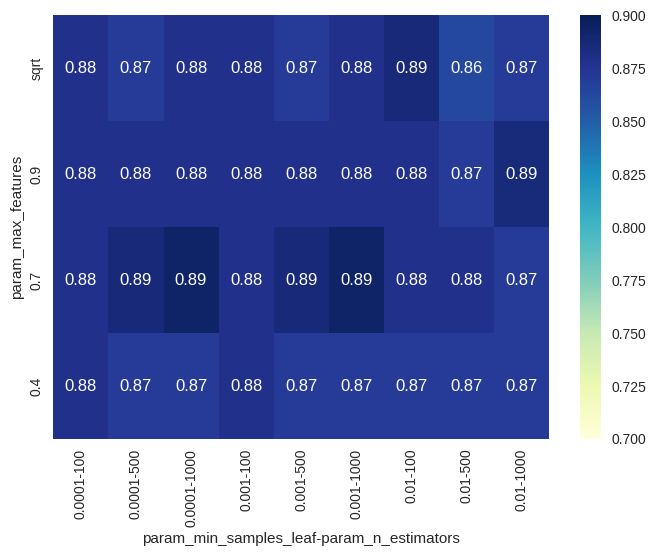

In [86]:
ax = sns.heatmap(pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7,
                 vmax=0.9)
ax.invert_yaxis()

### Feature importances

In [71]:
for col, val in sorted(
    zip(
        X_train.columns,
        rf_best.feature_importances_,
    ),
    key=lambda x: x[1],
    reverse=True,
)[:]:
    print(f"{col:10}{val:10.3f}")

fractional-shortening     0.313
lvdd           0.223
survival       0.161
epss           0.128
age-at-heart-attack     0.089
wall-motion-index     0.050
wall-motion-score     0.033
pericardial-effusion     0.003


([<matplotlib.axis.XTick at 0x7ff18e559690>,
 [Text(0, 0, 'fractional-shortening'),
  Text(1, 0, 'lvdd'),
  Text(2, 0, 'survival'),
  Text(3, 0, 'epss'),
  Text(4, 0, 'age-at-heart-attack'),
  Text(5, 0, 'wall-motion-index'),
  Text(6, 0, 'wall-motion-score'),
  Text(7, 0, 'pericardial-effusion')])

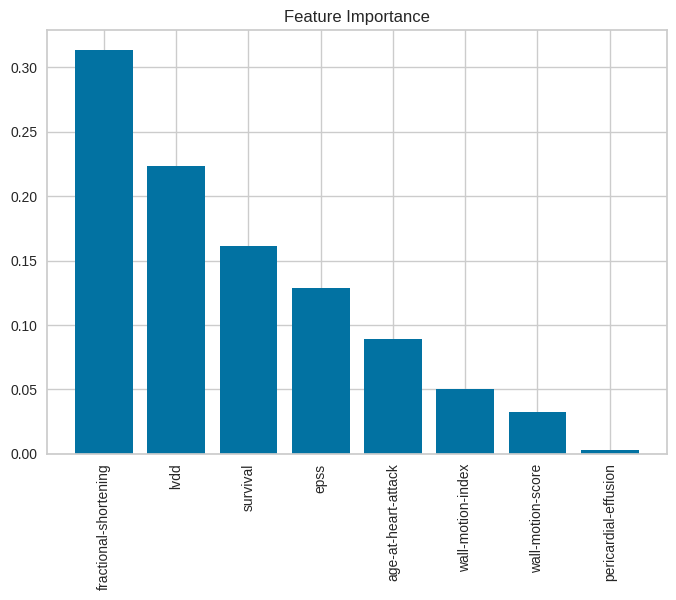

In [72]:
importances = rf_best.feature_importances_
indices = np.argsort(importances)[::-1]
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align='center')

plt.xticks(range(X_train.shape[1]),
            X_train.columns[indices], rotation=90)

The feature `pericardial-effusion` has low importance in the prediction model.

## Metrics and Evaluation

### Confusion matrix

/home/dmboup/miniconda/envs/env310/lib/python3.10/site-packages/yellowbrick/base.py:258: DeprecationWarning: this method is deprecated, please use show() instead
  warnings.warn(


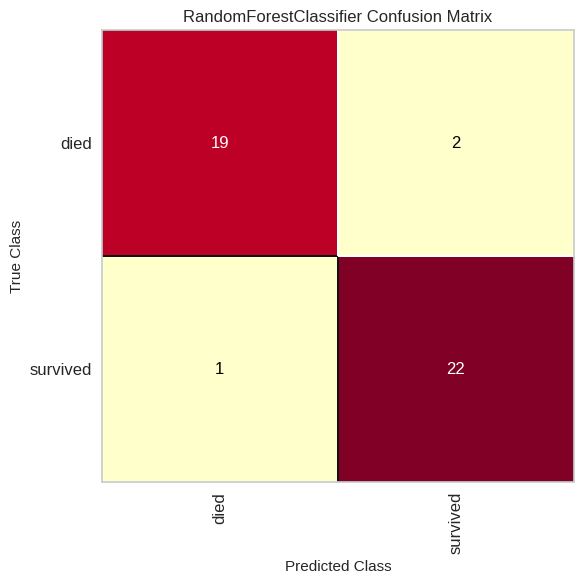

<AxesSubplot: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [74]:
import matplotlib.pyplot as plt
from yellowbrick.classifier import ConfusionMatrix


mapping = {0: "died", 1: "survived"}
fig, ax = plt.subplots(figsize=(6, 6))
cm_viz = ConfusionMatrix(
    rf_best,
    classes=["died", "survived"],
    label_encoder=mapping,
)
cm_viz.score(X_test, y_test)
cm_viz.poof()

### Classification report

In [75]:
from sklearn.metrics import classification_report
prediction = rf_best.predict(X_test)
print(classification_report(prediction, y_test))

              precision    recall  f1-score   support

           0       0.90      0.95      0.93        20
           1       0.96      0.92      0.94        24

    accuracy                           0.93        44
   macro avg       0.93      0.93      0.93        44
weighted avg       0.93      0.93      0.93        44



In [ ]:
### ROC CURVE

In [76]:
from yellowbrick.classifier import ROCAUC

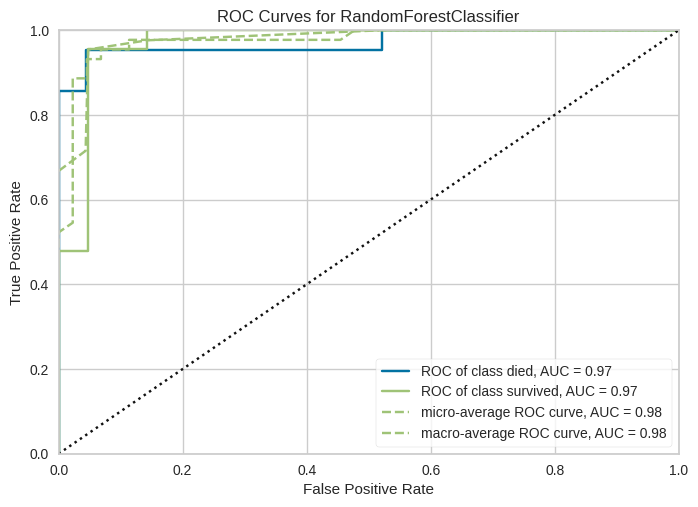

<AxesSubplot: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [77]:
visualizer = ROCAUC(rf_best, classes=["died", "survived"])

visualizer.fit(X_train, y_train)        # Fit the training data to the visualizer
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure


### Learning Curve

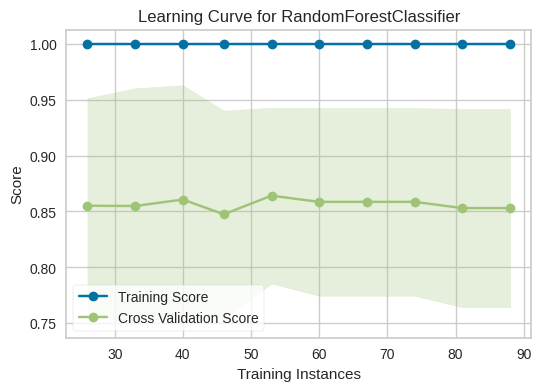

<AxesSubplot: title={'center': 'Learning Curve for RandomForestClassifier'}, xlabel='Training Instances', ylabel='Score'>

In [79]:
fig, ax = plt.subplots(figsize=(6, 4))
cv = StratifiedKFold(12)
sizes = np.linspace(0.3, 1.0, 10)
lc_viz = LearningCurve(
    rf_best,
    cv=cv,
    train_sizes=sizes,
    scoring="f1_weighted",
    n_jobs=-1,
    ax=ax,
)
lc_viz.fit(X, y)
lc_viz.show()

## Model Deployment